In [1]:
# https://www.kaggle.com/kratisaxena/stock-market-technical-indicators-visualization
# https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/notebooks
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import math
from collections import OrderedDict

---

In [2]:
# https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
stock_files = []
for filename in os.listdir("./Stocks/"):
    if (filename.endswith(".txt")):
        if(os.path.getsize("./Stocks/"+filename) > 0):
            stock_files.append(filename)
            
# choose a random subset of stocks
# random.seed(14)
# sequence = [i for i in range(len(stock_files))] 
# total_stocks = 10
# selected_stocks = [stock_files[i] for i in random.sample(sequence, total_stocks)] 
selected_stocks = stock_files

In [3]:
%%time
# Dataset read and preprocessing
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
stock_data = []
for stock in selected_stocks:
    df = pd.read_csv("./Stocks/"+stock, usecols=["Date", "Open", "High", "Low", "Close", "Volume"])
    st = stock.split(".us.txt")[0]
    df["Stock"] = st.upper()
    stock_data.append(df)
# concatenate all in one dataframe
stock_data = pd.concat(stock_data, ignore_index=True)

# convert Date to appropriate pandas format, and then sort by Date
stock_data["Date"] = pd.to_datetime(stock_data.Date)
stock_data = stock_data.sort_values(by="Date")

# get rid of stock prices that are zero in any of these columns (Open, High, Low, Close)
# https://stackoverflow.com/questions/49841989/python-drop-value-0-row-in-specific-columns
print("Previously :",stock_data.shape)
stock_data = stock_data.loc[stock_data["Open"] * stock_data["High"] * stock_data["Low"] * stock_data["Close"] != 0]
print("Now 1      :",stock_data.shape,"(after removing zeros in O, H, L, C columns)")


# now we will have intra-day trading. therefore, keep two new columns, that will store the two possible moves
# buy-open & sell-high or
# buy-low & sell-close
commission = 0.01
stock_data["O->H"] = stock_data["High"]*(1-commission) - stock_data["Open"]*(1+commission)
stock_data["L->C"] = stock_data["Close"]*(1-commission) - stock_data["Low"]*(1+commission)

# Also, get rid of stocks that have zero (or negative) value in any of these columns (bO-sH, bL-sC)
# we are interested only in intra-day trading, therefore a <=0 change in these columns offers nothing to us
stock_data = stock_data.drop(stock_data[(stock_data["O->H"]<=0) & (stock_data["L->C"]<=0)].index)
print("Now 2      :",stock_data.shape,"(after removing zeros and negatives in both O->H & L->C columns)")

# https://stackoverflow.com/a/12169357
# "MaxIntra" column contains the best change of stock price between O->H and L->C
# "MaxProfit" column contains the max profit between the two moves, considering that we buy 10% of stock volume
# It is used as a metric to choose which stocks we will examine in each day (we will sort by this column later)
stock_data["MaxIntra"]  = stock_data[["O->H", "L->C"]].max(axis=1)
stock_data["MaxProfit"] = stock_data["MaxIntra"] * stock_data["Volume"].apply(lambda x: math.floor(x*0.1))

# reset once again to fix index of each stock
stock_data.reset_index(inplace=True, drop=True)
print(stock_data)

Previously : (14887665, 7)
Now 1      : (14887638, 7) (after removing zeros in O, H, L, C columns)
Now 2      : (5079892, 9) (after removing zeros and negatives in both O->H & L->C columns)
              Date     Open     High      Low    Close   Volume Stock  \
0       1962-01-05   0.6122   0.6122   0.5798   0.5957  3255244    GE   
1       1962-01-08   0.5957   0.5957   0.5716   0.5957  3696430    GE   
2       1962-01-24   0.5878   0.6037   0.5878   0.6037  1907836    GE   
3       1962-01-31   5.8784   6.0036   5.8784   6.0036   916151   IBM   
4       1962-01-31   0.6037   0.6277   0.6037   0.6277  2241705    GE   
...            ...      ...      ...      ...      ...      ...   ...   
5079887 2017-11-10   3.8400   3.9872   3.8300   3.9300     4259  CLDC   
5079888 2017-11-10  13.2500  13.9550  13.1300  13.5700  2833227  HZNP   
5079889 2017-11-10   1.3500   1.4000   1.3500   1.3750   110703  RWLK   
5079890 2017-11-10   9.1220   9.1243   8.6914   9.0500    22669   TKF   
5079891

---

In [4]:
dates = stock_data.Date.unique()
start_date = pd.to_datetime(min(dates),format='%Y-%m-%d')
end_date   = pd.to_datetime(max(dates),format='%Y-%m-%d')

rem_trans = 1000000 # starting, 1M transactions are available
# find the maximum allowed transactions per day
# each move (O->H or L->C) is 2 transactions, therefore we will need to divide by 2 later
# adapt to the date range
# only weekdays are considered in dataset, therefore, adapt to it by multiplying range of dates by 5/7
# trans_per_day will be adjusted after each time step, to adapt to remaining transactions allowed
trans_per_day = math.floor(rem_trans/(((end_date-start_date).days)*(5/7)))
print("Allowed transactions per day are at first :", trans_per_day, \
      "( for dates between", start_date.date(), "and", end_date.date(), ")")
# For each stock we will need 2 transactions, therefore we will divide by 2 to select the first trans_per_day/2 stocks

Allowed transactions per day are at first : 68 ( for dates between 1962-01-05 and 2017-11-10 )


In [5]:
%%time
curr_day = start_date
cnt = 0       # id of time window
cnt2 = 1      # id of move
balance = 1   # starting with 1 dollar
commission = 0.01

win1 = pd.Timedelta(days=1)
# dictionary that will save the balance of each day
# Balance is our bank account
Balance_dict = {}

out_list = [] # log of moves, to save .txt file later
out_file = open("large_log.txt","w")

# now test day-by-day, no window used
while curr_day < end_date :
    filtered = (stock_data["Date"] == curr_day)

    # sort stocks of curr_day by the MaxProfit that can occur, and select the first trans_per_day/2, so that
    # we have many transactions remaining as we move forward to the dataset and have to examine more and more
    # stocks per day (especially after 90's)
    stocks_win = stock_data.loc[filtered].sort_values(by="MaxProfit",ascending=False).head(math.floor(trans_per_day/2))
    
    # temp_balance will only be reduced by which stock I buy, to check if I can make "safe" transactions
    # (meaning, those that I can really afford, and not rely on getting money back from selling during the day)
    temp_balance = balance # to check if I can actually buy
    temp_profit, temp_trans = 0, 0  # how much profit and how many transactions will occur during this date
    
    for ind,row in stocks_win.iterrows(): # iterate over available stocks this way, instead of "stock in stock_names_window"
        flag = 0 # "O->H"
        price_buy = row["Open"]*(1+commission)
        if(row["MaxIntra"] == row["L->C"]):
            flag = 1 # "L->C"
            price_buy = row["Low"]*(1+commission)
            
        # check if I can afford it (at least one of it!)
        if(price_buy <= temp_balance):
            # then buy it, at volume either what our temp_balance affords, or 10% of volume at that date
            volume = min(math.floor(temp_balance/price_buy), math.floor(row["Volume"]*0.1))
            # to make sure a transaction was made we have to have volume at least 1, 
            # to be allowed to make further transactions, and not exceed the daily limit of transactions
            if((volume>0) & (rem_trans>0) & (temp_trans<trans_per_day)):
                # a successful transaction!
                # reduce our temp_balance by the amount needed to buy specific stock
                temp_balance -= volume*price_buy
                rem_trans  -= 2 # reduce the remaining transactions by 2
                temp_trans += 2 # update current date transactions

                temp_profit += volume*row["MaxIntra"]
                # now I have to log them!
                if(flag==0): # "O->H"
                    out_list.append(str(curr_day.date()) + " buy-open " + row["Stock"] + " " + str(volume) + "\n")
                    out_list.append(str(curr_day.date()) + " sell-high " + row["Stock"] + " " + str(volume) + "\n")                    
                else: # "L->C"
                    out_list.append(str(curr_day.date()) + " buy-low " + row["Stock"] + " " + str(volume) + "\n")
                    out_list.append(str(curr_day.date()) + " sell-close " + row["Stock"] + " " + str(volume) + "\n")

    balance += temp_profit
    Balance_dict[str(curr_day.date())] = balance
    
    curr_day += win1
    if(curr_day == end_date):
        break
    
    trans_per_day = math.floor(rem_trans/(((end_date-curr_day).days)*(5/7)))

    # every 100 days print something to have some supervision over this whole damn thing
    if((temp_trans>0) & (cnt%100==0)): # if it was a busy day, output!
        print((curr_day-win1).date(),"| temp_trans :", temp_trans,"\t| day's profit = ", round(temp_profit,3), "\t| total transactions :", 1000000 - rem_trans)
        out_file.write(str((curr_day-win1).date())+" | temp_trans : "+str(temp_trans)+"\t| day's profit = "+str(round(temp_profit,3))+ "\t| total transactions :"+ str(1000000 - rem_trans)+"\n")
    if(cnt%500==0):
        print((curr_day-win1).date(),"Remaining transactions :", rem_trans, "( trans_per_day", trans_per_day, ") Balance :", balance,"\n")
        out_file.write(str((curr_day-win1).date())+" Remaining transactions : "+ str(rem_trans)+ " ( trans_per_day "+ str(trans_per_day)+ " ) Balance : "+ str(balance)+"\n\n")
        
    cnt+=1
    
out_file.close()

1962-01-05 | temp_trans : 2 	| day's profit =  0.004 	| total transactions : 2
1962-01-05 Remaining transactions : 999998 ( trans_per_day 68 ) Balance : 1.004145 

1962-11-01 | temp_trans : 2 	| day's profit =  0.01 	| total transactions : 66
1963-05-20 Remaining transactions : 999912 ( trans_per_day 70 ) Balance : 1.543801 

1964-10-01 Remaining transactions : 999866 ( trans_per_day 72 ) Balance : 1.697462999999999 

1966-02-13 Remaining transactions : 999848 ( trans_per_day 74 ) Balance : 1.766755999999999 

1967-06-28 Remaining transactions : 999730 ( trans_per_day 76 ) Balance : 2.2753739999999967 

1968-11-09 Remaining transactions : 999616 ( trans_per_day 78 ) Balance : 2.8432099999999956 

1969-05-28 | temp_trans : 2 	| day's profit =  0.002 	| total transactions : 422
1970-03-24 | temp_trans : 4 	| day's profit =  0.179 	| total transactions : 626
1970-03-24 Remaining transactions : 999374 ( trans_per_day 80 ) Balance : 15.262131799999976 

1970-07-02 | temp_trans : 4 	| day's 

1995-06-01 | temp_trans : 114 	| day's profit =  5173348.814 	| total transactions : 323260
1995-12-18 | temp_trans : 114 	| day's profit =  5772575.93 	| total transactions : 338426
1996-03-27 | temp_trans : 114 	| day's profit =  3580966.055 	| total transactions : 346212
1996-03-27 Remaining transactions : 653788 ( trans_per_day 115 ) Balance : 6202914308.575227 

1996-07-05 | temp_trans : 76 	| day's profit =  505840.958 	| total transactions : 353742
1997-01-21 | temp_trans : 116 	| day's profit =  27851450.277 	| total transactions : 369274
1997-05-01 | temp_trans : 116 	| day's profit =  9172703.829 	| total transactions : 377322
1997-08-09 Remaining transactions : 614718 ( trans_per_day 116 ) Balance : 8943054697.780336 

1997-11-17 | temp_trans : 116 	| day's profit =  9805557.213 	| total transactions : 393300
1998-02-25 | temp_trans : 116 	| day's profit =  11411346.693 	| total transactions : 401012
1998-06-05 | temp_trans : 116 	| day's profit =  12000689.211 	| total tran

In [6]:
tot_moves = len(out_list)

print("Finally, balance is :", balance, "after", tot_moves, "moves")

out_file = open("large.txt","w")

out_file.write(str(tot_moves)+"\n") # first, write total count of moves
for move in out_list:               # then write every move that occured
    out_file.write(move)

out_file.close()

Finally, balance is : 295659440855.4203 after 1000000 moves


---

In [7]:
print((end_date-start_date).days)
print(len(Balance_dict))
# Some dates are missing, because no transaction was made within some time windows
# Have to fill these gaps (the last date it is!)

20398
20398


In [8]:
new_date = start_date
while (new_date<=end_date):
    # what stands for Balance stands also for Portfolio, as they are created together
    if(str(new_date.date()) not in Balance_dict.keys()): 
        Balance_dict[str(new_date.date())] = Balance_dict[str((new_date-win1).date())]
    new_date+=win1

# after filling the gaps, order/sort the dictionary, so that dates are aligned correctly
Balance_dict = OrderedDict(sorted(Balance_dict.items(), key=lambda t: t[0]))

In [9]:
out_file = open("large_valuation.txt","w")

print((end_date-start_date).days)
print(len(Balance_dict))
for i in Balance_dict:
    print(i, " :Balance:",Balance_dict[i])
    out_file.write(str(i) + ":Balance: " + str(Balance_dict[i]) + "\n")
    
out_file.close()

20398
20399
1962-01-05  :Balance: 1.004145
1962-01-06  :Balance: 1.004145
1962-01-07  :Balance: 1.004145
1962-01-08  :Balance: 1.016572
1962-01-09  :Balance: 1.016572
1962-01-10  :Balance: 1.016572
1962-01-11  :Balance: 1.016572
1962-01-12  :Balance: 1.016572
1962-01-13  :Balance: 1.016572
1962-01-14  :Balance: 1.016572
1962-01-15  :Balance: 1.016572
1962-01-16  :Balance: 1.016572
1962-01-17  :Balance: 1.016572
1962-01-18  :Balance: 1.016572
1962-01-19  :Balance: 1.016572
1962-01-20  :Balance: 1.016572
1962-01-21  :Balance: 1.016572
1962-01-22  :Balance: 1.016572
1962-01-23  :Balance: 1.016572
1962-01-24  :Balance: 1.0205570000000002
1962-01-25  :Balance: 1.0205570000000002
1962-01-26  :Balance: 1.0205570000000002
1962-01-27  :Balance: 1.0205570000000002
1962-01-28  :Balance: 1.0205570000000002
1962-01-29  :Balance: 1.0205570000000002
1962-01-30  :Balance: 1.0205570000000002
1962-01-31  :Balance: 1.0322430000000002
1962-02-01  :Balance: 1.0322430000000002
1962-02-02  :Balance: 1.032243

1964-06-04  :Balance: 1.6646209999999995
1964-06-05  :Balance: 1.6646209999999995
1964-06-06  :Balance: 1.6646209999999995
1964-06-07  :Balance: 1.6646209999999995
1964-06-08  :Balance: 1.6646209999999995
1964-06-09  :Balance: 1.6646209999999995
1964-06-10  :Balance: 1.6646209999999995
1964-06-11  :Balance: 1.6646209999999995
1964-06-12  :Balance: 1.6646209999999995
1964-06-13  :Balance: 1.6646209999999995
1964-06-14  :Balance: 1.6646209999999995
1964-06-15  :Balance: 1.6646209999999995
1964-06-16  :Balance: 1.6646209999999995
1964-06-17  :Balance: 1.6646209999999995
1964-06-18  :Balance: 1.6646209999999995
1964-06-19  :Balance: 1.6646209999999995
1964-06-20  :Balance: 1.6646209999999995
1964-06-21  :Balance: 1.6646209999999995
1964-06-22  :Balance: 1.6646209999999995
1964-06-23  :Balance: 1.6646209999999995
1964-06-24  :Balance: 1.6646209999999995
1964-06-25  :Balance: 1.6646209999999995
1964-06-26  :Balance: 1.6646209999999995
1964-06-27  :Balance: 1.6646209999999995
1964-06-28  :Bal

1967-08-15  :Balance: 2.4393639999999968
1967-08-16  :Balance: 2.4393639999999968
1967-08-17  :Balance: 2.4393639999999968
1967-08-18  :Balance: 2.4393639999999968
1967-08-19  :Balance: 2.4393639999999968
1967-08-20  :Balance: 2.4393639999999968
1967-08-21  :Balance: 2.4393639999999968
1967-08-22  :Balance: 2.4393639999999968
1967-08-23  :Balance: 2.4393639999999968
1967-08-24  :Balance: 2.4393639999999968
1967-08-25  :Balance: 2.4393639999999968
1967-08-26  :Balance: 2.4393639999999968
1967-08-27  :Balance: 2.4393639999999968
1967-08-28  :Balance: 2.4393639999999968
1967-08-29  :Balance: 2.4393639999999968
1967-08-30  :Balance: 2.4393639999999968
1967-08-31  :Balance: 2.4393639999999968
1967-09-01  :Balance: 2.4393639999999968
1967-09-02  :Balance: 2.4393639999999968
1967-09-03  :Balance: 2.4393639999999968
1967-09-04  :Balance: 2.4393639999999968
1967-09-05  :Balance: 2.4393639999999968
1967-09-06  :Balance: 2.4393639999999968
1967-09-07  :Balance: 2.4393639999999968
1967-09-08  :Bal

1969-11-25  :Balance: 3.3216649999999923
1969-11-26  :Balance: 3.3216649999999923
1969-11-27  :Balance: 3.3216649999999923
1969-11-28  :Balance: 3.3216649999999923
1969-11-29  :Balance: 3.3216649999999923
1969-11-30  :Balance: 3.3216649999999923
1969-12-01  :Balance: 3.3216649999999923
1969-12-02  :Balance: 3.3216649999999923
1969-12-03  :Balance: 3.3216649999999923
1969-12-04  :Balance: 3.4169399999999923
1969-12-05  :Balance: 3.4169399999999923
1969-12-06  :Balance: 3.4169399999999923
1969-12-07  :Balance: 3.4169399999999923
1969-12-08  :Balance: 3.4169399999999923
1969-12-09  :Balance: 3.4317199999999923
1969-12-10  :Balance: 3.4472049999999923
1969-12-11  :Balance: 3.4472049999999923
1969-12-12  :Balance: 3.4472049999999923
1969-12-13  :Balance: 3.4472049999999923
1969-12-14  :Balance: 3.4472049999999923
1969-12-15  :Balance: 3.4472049999999923
1969-12-16  :Balance: 3.4472049999999923
1969-12-17  :Balance: 3.4472049999999923
1969-12-18  :Balance: 3.4648899999999925
1969-12-19  :Bal

1973-02-04  :Balance: 2583103.2674926952
1973-02-05  :Balance: 2587904.3666226952
1973-02-06  :Balance: 2603513.9494936955
1973-02-07  :Balance: 2625535.7004102953
1973-02-08  :Balance: 2641277.9415822956
1973-02-09  :Balance: 2671653.5449088956
1973-02-10  :Balance: 2671653.5449088956
1973-02-11  :Balance: 2671653.5449088956
1973-02-12  :Balance: 2681399.021142896
1973-02-13  :Balance: 2700007.921573896
1973-02-14  :Balance: 2700067.289511196
1973-02-15  :Balance: 2704461.996188196
1973-02-16  :Balance: 2729349.228612696
1973-02-17  :Balance: 2729349.228612696
1973-02-18  :Balance: 2729349.228612696
1973-02-19  :Balance: 2729349.228612696
1973-02-20  :Balance: 2729631.470108696
1973-02-21  :Balance: 2729924.732360196
1973-02-22  :Balance: 2733715.995158196
1973-02-23  :Balance: 2733715.995158196
1973-02-24  :Balance: 2733715.995158196
1973-02-25  :Balance: 2733715.995158196
1973-02-26  :Balance: 2765203.337091396
1973-02-27  :Balance: 2765458.5740229962
1973-02-28  :Balance: 2798439.0

1975-05-18  :Balance: 19170133.477430362
1975-05-19  :Balance: 19202445.641245764
1975-05-20  :Balance: 19203644.182294164
1975-05-21  :Balance: 19203663.989157163
1975-05-22  :Balance: 19207568.760514762
1975-05-23  :Balance: 19214191.191264763
1975-05-24  :Balance: 19214191.191264763
1975-05-25  :Balance: 19214191.191264763
1975-05-26  :Balance: 19214191.191264763
1975-05-27  :Balance: 19218510.461186364
1975-05-28  :Balance: 19219773.148249365
1975-05-29  :Balance: 19222232.513996966
1975-05-30  :Balance: 19241067.900145367
1975-05-31  :Balance: 19241067.900145367
1975-06-01  :Balance: 19241067.900145367
1975-06-02  :Balance: 19264894.518924467
1975-06-03  :Balance: 19280210.186023667
1975-06-04  :Balance: 19284391.46981767
1975-06-05  :Balance: 19307925.472002868
1975-06-06  :Balance: 19309778.15165487
1975-06-07  :Balance: 19309778.15165487
1975-06-08  :Balance: 19309778.15165487
1975-06-09  :Balance: 19318168.09786287
1975-06-10  :Balance: 19365728.98192087
1975-06-11  :Balance: 

1978-07-27  :Balance: 31972238.787017055
1978-07-28  :Balance: 31989960.188980155
1978-07-29  :Balance: 31989960.188980155
1978-07-30  :Balance: 31989960.188980155
1978-07-31  :Balance: 32068588.112767756
1978-08-01  :Balance: 32103992.181348555
1978-08-02  :Balance: 32718429.214391656
1978-08-03  :Balance: 32895740.154271357
1978-08-04  :Balance: 32994016.296365358
1978-08-05  :Balance: 32994016.296365358
1978-08-06  :Balance: 32994016.296365358
1978-08-07  :Balance: 33045707.901253257
1978-08-08  :Balance: 33206594.042354956
1978-08-09  :Balance: 33256084.910354957
1978-08-10  :Balance: 33256927.06661796
1978-08-11  :Balance: 33300175.815628957
1978-08-12  :Balance: 33300175.815628957
1978-08-13  :Balance: 33300175.815628957
1978-08-14  :Balance: 33308606.36660576
1978-08-15  :Balance: 33321667.37512036
1978-08-16  :Balance: 33388988.26595726
1978-08-17  :Balance: 33434506.00100206
1978-08-18  :Balance: 33611005.94293026
1978-08-19  :Balance: 33611005.94293026
1978-08-20  :Balance: 3

1980-11-06  :Balance: 63161301.671093166
1980-11-07  :Balance: 63199944.45195237
1980-11-08  :Balance: 63199944.45195237
1980-11-09  :Balance: 63199944.45195237
1980-11-10  :Balance: 63220964.63802697
1980-11-11  :Balance: 63518864.32007416
1980-11-12  :Balance: 65271856.77794047
1980-11-13  :Balance: 65951692.34284767
1980-11-14  :Balance: 66052825.98126507
1980-11-15  :Balance: 66052825.98126507
1980-11-16  :Balance: 66052825.98126507
1980-11-17  :Balance: 66290078.92587027
1980-11-18  :Balance: 66563716.73124687
1980-11-19  :Balance: 66793719.25020387
1980-11-20  :Balance: 66996109.21837777
1980-11-21  :Balance: 67005555.57721487
1980-11-22  :Balance: 67005555.57721487
1980-11-23  :Balance: 67005555.57721487
1980-11-24  :Balance: 67041548.148596264
1980-11-25  :Balance: 67119550.72487496
1980-11-26  :Balance: 67301937.46133326
1980-11-27  :Balance: 67301937.46133326
1980-11-28  :Balance: 67336747.64077117
1980-11-29  :Balance: 67336747.64077117
1980-11-30  :Balance: 67336747.6407711

1984-01-17  :Balance: 338704755.5711678
1984-01-18  :Balance: 338796289.76686984
1984-01-19  :Balance: 338844786.30000687
1984-01-20  :Balance: 338896170.9114029
1984-01-21  :Balance: 338896170.9114029
1984-01-22  :Balance: 338896170.9114029
1984-01-23  :Balance: 338963676.8998269
1984-01-24  :Balance: 339082491.98032707
1984-01-25  :Balance: 340686779.93287313
1984-01-26  :Balance: 340781571.3196907
1984-01-27  :Balance: 341027714.6851976
1984-01-28  :Balance: 341027714.6851976
1984-01-29  :Balance: 341027714.6851976
1984-01-30  :Balance: 341108584.86621886
1984-01-31  :Balance: 341353794.85177207
1984-02-01  :Balance: 341458778.7854628
1984-02-02  :Balance: 341972180.6647568
1984-02-03  :Balance: 342031728.21552175
1984-02-04  :Balance: 342031728.21552175
1984-02-05  :Balance: 342031728.21552175
1984-02-06  :Balance: 342492534.4507905
1984-02-07  :Balance: 343520640.5058543
1984-02-08  :Balance: 343574299.8783179
1984-02-09  :Balance: 344514806.0570313
1984-02-10  :Balance: 344986119

1986-04-29  :Balance: 662710694.9999175
1986-04-30  :Balance: 662880148.2423037
1986-05-01  :Balance: 663467602.9042829
1986-05-02  :Balance: 663739280.9833342
1986-05-03  :Balance: 663739280.9833342
1986-05-04  :Balance: 663739280.9833342
1986-05-05  :Balance: 664235607.2868745
1986-05-06  :Balance: 664985260.0311646
1986-05-07  :Balance: 665464477.7929951
1986-05-08  :Balance: 666109417.1931169
1986-05-09  :Balance: 666496425.7555194
1986-05-10  :Balance: 666496425.7555194
1986-05-11  :Balance: 666496425.7555194
1986-05-12  :Balance: 667184680.367392
1986-05-13  :Balance: 667484072.288422
1986-05-14  :Balance: 668344819.4477873
1986-05-15  :Balance: 668519283.1804383
1986-05-16  :Balance: 669282657.89734
1986-05-17  :Balance: 669282657.89734
1986-05-18  :Balance: 669282657.89734
1986-05-19  :Balance: 669485642.6004831
1986-05-20  :Balance: 670557484.082004
1986-05-21  :Balance: 670932438.8227446
1986-05-22  :Balance: 672187056.0708324
1986-05-23  :Balance: 672479712.0800765
1986-05-2

1989-07-09  :Balance: 1812500634.79373
1989-07-10  :Balance: 1812867867.4018462
1989-07-11  :Balance: 1813125029.7176428
1989-07-12  :Balance: 1813517204.7601957
1989-07-13  :Balance: 1813828918.4999583
1989-07-14  :Balance: 1814415949.0309408
1989-07-15  :Balance: 1814415949.0309408
1989-07-16  :Balance: 1814415949.0309408
1989-07-17  :Balance: 1814896360.139631
1989-07-18  :Balance: 1815315198.7265131
1989-07-19  :Balance: 1817257952.1713
1989-07-20  :Balance: 1817691954.60777
1989-07-21  :Balance: 1819171497.5098891
1989-07-22  :Balance: 1819171497.5098891
1989-07-23  :Balance: 1819171497.5098891
1989-07-24  :Balance: 1819574513.9333665
1989-07-25  :Balance: 1820557364.2645655
1989-07-26  :Balance: 1823988887.2428062
1989-07-27  :Balance: 1825285900.1138134
1989-07-28  :Balance: 1825579823.4191184
1989-07-29  :Balance: 1825579823.4191184
1989-07-30  :Balance: 1825579823.4191184
1989-07-31  :Balance: 1826660479.7290168
1989-08-01  :Balance: 1827337313.4429815
1989-08-02  :Balance: 18

1991-10-20  :Balance: 2662307364.1236467
1991-10-21  :Balance: 2662720549.654286
1991-10-22  :Balance: 2663800768.80174
1991-10-23  :Balance: 2664915044.9086213
1991-10-24  :Balance: 2665559092.6750183
1991-10-25  :Balance: 2666175594.6536975
1991-10-26  :Balance: 2666175594.6536975
1991-10-27  :Balance: 2666175594.6536975
1991-10-28  :Balance: 2667702400.9536147
1991-10-29  :Balance: 2669000725.721439
1991-10-30  :Balance: 2670811331.4579535
1991-10-31  :Balance: 2672125200.3194795
1991-11-01  :Balance: 2672695067.2885857
1991-11-02  :Balance: 2672695067.2885857
1991-11-03  :Balance: 2672695067.2885857
1991-11-04  :Balance: 2673228608.6742373
1991-11-05  :Balance: 2673884693.1251287
1991-11-06  :Balance: 2674428441.41005
1991-11-07  :Balance: 2676939284.6170974
1991-11-08  :Balance: 2677957935.491068
1991-11-09  :Balance: 2677957935.491068
1991-11-10  :Balance: 2677957935.491068
1991-11-11  :Balance: 2678469322.3122716
1991-11-12  :Balance: 2679706768.356024
1991-11-13  :Balance: 2681

1994-12-29  :Balance: 4427365467.426938
1994-12-30  :Balance: 4427877210.023111
1994-12-31  :Balance: 4427877210.023111
1995-01-01  :Balance: 4427877210.023111
1995-01-02  :Balance: 4427877210.023111
1995-01-03  :Balance: 4428887463.43773
1995-01-04  :Balance: 4431128239.928031
1995-01-05  :Balance: 4432488786.270931
1995-01-06  :Balance: 4435479444.470659
1995-01-07  :Balance: 4435479444.470659
1995-01-08  :Balance: 4435479444.470659
1995-01-09  :Balance: 4436323741.75477
1995-01-10  :Balance: 4439368625.531955
1995-01-11  :Balance: 4442900292.683613
1995-01-12  :Balance: 4444728835.243827
1995-01-13  :Balance: 4446534327.322366
1995-01-14  :Balance: 4446534327.322366
1995-01-15  :Balance: 4446534327.322366
1995-01-16  :Balance: 4451101589.482318
1995-01-17  :Balance: 4454204327.351142
1995-01-18  :Balance: 4454715938.111633
1995-01-19  :Balance: 4455673822.740798
1995-01-20  :Balance: 4456063723.957241
1995-01-21  :Balance: 4456063723.957241
1995-01-22  :Balance: 4456063723.957241
19

1997-04-10  :Balance: 8001594840.265833
1997-04-11  :Balance: 8005430497.225761
1997-04-12  :Balance: 8005430497.225761
1997-04-13  :Balance: 8005430497.225761
1997-04-14  :Balance: 8017009733.952567
1997-04-15  :Balance: 8021878441.187775
1997-04-16  :Balance: 8039587276.143822
1997-04-17  :Balance: 8058636357.219025
1997-04-18  :Balance: 8071295966.15099
1997-04-19  :Balance: 8071295966.15099
1997-04-20  :Balance: 8071295966.15099
1997-04-21  :Balance: 8079052690.077606
1997-04-22  :Balance: 8098177101.372886
1997-04-23  :Balance: 8119329031.471045
1997-04-24  :Balance: 8128899805.911299
1997-04-25  :Balance: 8131941441.132622
1997-04-26  :Balance: 8131941441.132622
1997-04-27  :Balance: 8131941441.132622
1997-04-28  :Balance: 8143112993.967556
1997-04-29  :Balance: 8161474740.142695
1997-04-30  :Balance: 8180513430.967298
1997-05-01  :Balance: 8189686134.796734
1997-05-02  :Balance: 8214389470.012835
1997-05-03  :Balance: 8214389470.012835
1997-05-04  :Balance: 8214389470.012835
199

2000-06-20  :Balance: 43515373187.038895
2000-06-21  :Balance: 43629906558.21241
2000-06-22  :Balance: 43685309781.96907
2000-06-23  :Balance: 43714539044.03253
2000-06-24  :Balance: 43714539044.03253
2000-06-25  :Balance: 43714539044.03253
2000-06-26  :Balance: 43760749898.022896
2000-06-27  :Balance: 43812442252.79215
2000-06-28  :Balance: 43884002942.20106
2000-06-29  :Balance: 43947607857.242004
2000-06-30  :Balance: 44036239713.41395
2000-07-01  :Balance: 44036239713.41395
2000-07-02  :Balance: 44036239713.41395
2000-07-03  :Balance: 44058649060.69157
2000-07-04  :Balance: 44058649060.69157
2000-07-05  :Balance: 44096273846.18091
2000-07-06  :Balance: 44200645005.957085
2000-07-07  :Balance: 44255263654.193375
2000-07-08  :Balance: 44255263654.193375
2000-07-09  :Balance: 44255263654.193375
2000-07-10  :Balance: 44314399310.75471
2000-07-11  :Balance: 44363431476.95801
2000-07-12  :Balance: 44445995576.032524
2000-07-13  :Balance: 44529487595.73071
2000-07-14  :Balance: 4460869680

2002-10-01  :Balance: 79897425937.28894
2002-10-02  :Balance: 79930344272.16748
2002-10-03  :Balance: 79955343680.96239
2002-10-04  :Balance: 79976617597.03227
2002-10-05  :Balance: 79976617597.03227
2002-10-06  :Balance: 79976617597.03227
2002-10-07  :Balance: 79998602043.85345
2002-10-08  :Balance: 80067795128.19743
2002-10-09  :Balance: 80121826692.96014
2002-10-10  :Balance: 80271358834.56255
2002-10-11  :Balance: 80379289476.64981
2002-10-12  :Balance: 80379289476.64981
2002-10-13  :Balance: 80379289476.64981
2002-10-14  :Balance: 80421016922.86275
2002-10-15  :Balance: 80506952160.807
2002-10-16  :Balance: 80531406937.97119
2002-10-17  :Balance: 80576924274.92302
2002-10-18  :Balance: 80634873493.76408
2002-10-19  :Balance: 80634873493.76408
2002-10-20  :Balance: 80634873493.76408
2002-10-21  :Balance: 80722417605.41628
2002-10-22  :Balance: 80793417187.40074
2002-10-23  :Balance: 80871042614.1663
2002-10-24  :Balance: 80906866655.13559
2002-10-25  :Balance: 80964485189.62012
200

2005-12-11  :Balance: 97750479913.07469
2005-12-12  :Balance: 97764162734.66574
2005-12-13  :Balance: 97790477063.42378
2005-12-14  :Balance: 97816268961.4233
2005-12-15  :Balance: 97841307311.98425
2005-12-16  :Balance: 97867498685.48985
2005-12-17  :Balance: 97867498685.48985
2005-12-18  :Balance: 97867498685.48985
2005-12-19  :Balance: 97889435617.51782
2005-12-20  :Balance: 97906516933.22382
2005-12-21  :Balance: 97925614969.73294
2005-12-22  :Balance: 97949449934.85126
2005-12-23  :Balance: 97958884022.67691
2005-12-24  :Balance: 97958884022.67691
2005-12-25  :Balance: 97958884022.67691
2005-12-26  :Balance: 97958884022.67691
2005-12-27  :Balance: 97964116818.23686
2005-12-28  :Balance: 97971964897.9834
2005-12-29  :Balance: 97978548992.23592
2005-12-30  :Balance: 97983592106.18173
2005-12-31  :Balance: 97983592106.18173
2006-01-01  :Balance: 97983592106.18173
2006-01-02  :Balance: 97983592106.18173
2006-01-03  :Balance: 98051477538.7865
2006-01-04  :Balance: 98075390713.0215
2006

2008-03-23  :Balance: 127016495759.44008
2008-03-24  :Balance: 127222208298.84254
2008-03-25  :Balance: 127306208481.50345
2008-03-26  :Balance: 127383740849.43217
2008-03-27  :Balance: 127412271515.56592
2008-03-28  :Balance: 127438931566.90175
2008-03-29  :Balance: 127438931566.90175
2008-03-30  :Balance: 127438931566.90175
2008-03-31  :Balance: 127500395123.67418
2008-04-01  :Balance: 127681685388.73138
2008-04-02  :Balance: 127784324090.07864
2008-04-03  :Balance: 127934570612.96742
2008-04-04  :Balance: 128035411714.64299
2008-04-05  :Balance: 128035411714.64299
2008-04-06  :Balance: 128035411714.64299
2008-04-07  :Balance: 128066067961.73079
2008-04-08  :Balance: 128121076364.47572
2008-04-09  :Balance: 128150155381.15031
2008-04-10  :Balance: 128214494697.64938
2008-04-11  :Balance: 128238302602.58807
2008-04-12  :Balance: 128238302602.58807
2008-04-13  :Balance: 128238302602.58807
2008-04-14  :Balance: 128315908991.08699
2008-04-15  :Balance: 128344789564.17915
2008-04-16  :Bal

2011-06-02  :Balance: 209513860336.41608
2011-06-03  :Balance: 209544175810.0499
2011-06-04  :Balance: 209544175810.0499
2011-06-05  :Balance: 209544175810.0499
2011-06-06  :Balance: 209552762431.92914
2011-06-07  :Balance: 209579316840.86655
2011-06-08  :Balance: 209595290136.09314
2011-06-09  :Balance: 209629120874.92493
2011-06-10  :Balance: 209650554190.12946
2011-06-11  :Balance: 209650554190.12946
2011-06-12  :Balance: 209650554190.12946
2011-06-13  :Balance: 209667146706.73328
2011-06-14  :Balance: 209724830352.98068
2011-06-15  :Balance: 209737122915.8742
2011-06-16  :Balance: 209758645658.05078
2011-06-17  :Balance: 209772646370.602
2011-06-18  :Balance: 209772646370.602
2011-06-19  :Balance: 209772646370.602
2011-06-20  :Balance: 209793815684.985
2011-06-21  :Balance: 209878060136.2267
2011-06-22  :Balance: 209900081762.96762
2011-06-23  :Balance: 209985784706.4372
2011-06-24  :Balance: 209999993865.93384
2011-06-25  :Balance: 209999993865.93384
2011-06-26  :Balance: 20999999

2013-09-12  :Balance: 234470328054.31137
2013-09-13  :Balance: 234489494428.7413
2013-09-14  :Balance: 234489494428.7413
2013-09-15  :Balance: 234489494428.7413
2013-09-16  :Balance: 234505756345.34882
2013-09-17  :Balance: 234555579257.50638
2013-09-18  :Balance: 234641478688.49854
2013-09-19  :Balance: 234682569610.2137
2013-09-20  :Balance: 234745436594.1871
2013-09-21  :Balance: 234745436594.1871
2013-09-22  :Balance: 234745436594.1871
2013-09-23  :Balance: 234775264687.6681
2013-09-24  :Balance: 234804157069.98495
2013-09-25  :Balance: 234838799512.85016
2013-09-26  :Balance: 234870743525.48172
2013-09-27  :Balance: 234902381273.53958
2013-09-28  :Balance: 234902381273.53958
2013-09-29  :Balance: 234902381273.53958
2013-09-30  :Balance: 234935130675.13144
2013-10-01  :Balance: 234973049090.68546
2013-10-02  :Balance: 235010935294.70914
2013-10-03  :Balance: 235037490420.6715
2013-10-04  :Balance: 235082807899.33487
2013-10-05  :Balance: 235082807899.33487
2013-10-06  :Balance: 235

2016-11-22  :Balance: 282800156657.6925
2016-11-23  :Balance: 282879816154.34326
2016-11-24  :Balance: 282879816154.34326
2016-11-25  :Balance: 282890064260.2948
2016-11-26  :Balance: 282890064260.2948
2016-11-27  :Balance: 282890064260.2948
2016-11-28  :Balance: 282918002399.4031
2016-11-29  :Balance: 282963663173.96674
2016-11-30  :Balance: 283122539892.4021
2016-12-01  :Balance: 283177778242.1453
2016-12-02  :Balance: 283246732936.17944
2016-12-03  :Balance: 283246732936.17944
2016-12-04  :Balance: 283246732936.17944
2016-12-05  :Balance: 283284057191.00714
2016-12-06  :Balance: 283356056057.3038
2016-12-07  :Balance: 283442468989.1844
2016-12-08  :Balance: 283501435969.99603
2016-12-09  :Balance: 283548027405.24164
2016-12-10  :Balance: 283548027405.24164
2016-12-11  :Balance: 283548027405.24164
2016-12-12  :Balance: 283606949521.75995
2016-12-13  :Balance: 283655355030.0482
2016-12-14  :Balance: 283709044476.86945
2016-12-15  :Balance: 283762629670.9004
2016-12-16  :Balance: 28379

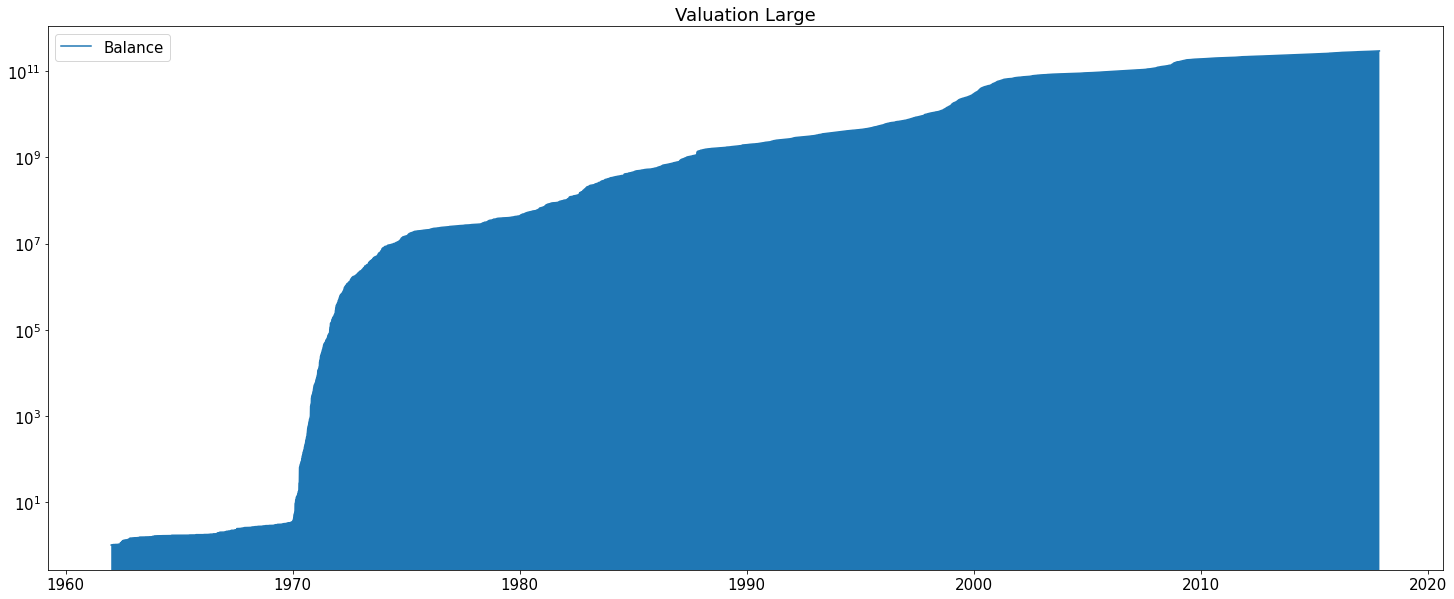

In [10]:
# now we are ready to create our plot!
dates_full = pd.date_range(start=start_date,end=end_date) # create the x axis

plt.figure(figsize=(25, 10))
plt.rcParams.update({'font.size': 15})
plt.plot(dates_full, Balance_dict.values())
plt.yscale("log") # have to use log scale for the plot to be acceptable

# https://www.geeksforgeeks.org/matplotlib-pyplot-fill_between-in-python/
# fill area between x axis and blue line with the balance values
plt.fill_between(dates_full, Balance_dict.values()) 

plt.legend(["Balance"])
plt.title("Valuation Large")
plt.savefig("large.png")
plt.show()